In [1]:
# CS3205 Networks - Assignment 3
# CS22B007, CS22B008
# TA group 1

import numpy as np
from collections import defaultdict
import re


In [2]:
### Reading the generated traceroute log data ###
# Load traceroute log data
with open('traceroute_log.txt', 'r') as f:
    log_data = f.read()

# Regex pattern to extract IPs and valid RTTs
pattern = re.compile(r'(\d+\.\d+\.\d+\.\d+).*?((?:\d+\.\d+\s*ms\s*)+)')

# Extract all matches
matches = pattern.findall(log_data)

#  Total valid RTT entries
total_valid_rtt = len(matches)
print(f"Total valid RTT entries: {total_valid_rtt}") # Solution to 1(a)


Total valid RTT entries: 5279


In [3]:
### Finding number of unique router IPs, and other statistics ###

rtt_data = defaultdict(list)

for match in matches:
    ip = match[0]
    rtt_values = re.findall(r'(\d+\.\d+)\s*ms', match[1])
    for rtt in rtt_values:
        rtt_data[ip].append(float(rtt))

# Calculate statistics
rtt_stats = {}
for ip, values in rtt_data.items():
    rtt_stats[ip] = {
        'avg_rtt': np.mean(values),
        'std_dev': np.std(values),
        'measurement_count': len(values)
    }

# Sort by standard deviation descending
top_std = sorted(rtt_stats.items(), key=lambda x: x[1]['std_dev'], reverse=True)[:5]

# Print results - Solution to 1(b)
print("Number of unique router IPs:", len(rtt_stats))  
print(f"{'Router IP':16} | {'Average RTT':14} | {'Standard Deviation':20} | {'Measurement Count':17}")
for ip, stats in rtt_stats.items():
    print(f"{ip:16} | {stats['avg_rtt']:11.2f} ms | {stats['std_dev']:17.2f} ms | {stats['measurement_count']:17}")

print("\nTop 5 routers by RTT standard deviation:")
for ip, stats in top_std:
    print(f"{ip:16} | {stats['avg_rtt']:11.2f} ms | {stats['std_dev']:17.2f} ms | {stats['measurement_count']:17}")


Number of unique router IPs: 233
Router IP        | Average RTT    | Standard Deviation   | Measurement Count
192.168.85.208   |        3.00 ms |              4.35 ms |               450
255.0.0.0        |       36.55 ms |             18.34 ms |               450
255.0.0.2        |       43.33 ms |             23.85 ms |               450
255.0.0.3        |       45.04 ms |             27.49 ms |               450
172.27.251.99    |       47.68 ms |             28.77 ms |               240
172.27.251.98    |       50.05 ms |             33.19 ms |               210
192.168.142.20   |       48.01 ms |             37.17 ms |                56
192.168.142.22   |       44.83 ms |             20.09 ms |                59
192.168.138.226  |       46.74 ms |             17.11 ms |                54
103.198.140.174  |       78.63 ms |             34.07 ms |               208
103.198.140.105  |      177.99 ms |             22.43 ms |                25
103.198.140.54   |      198.03 ms |        

In [4]:
import re
import numpy as np

IITM_lat_lon = (12.99151, 80.23362)

def parse_traceroute_logs(filename):
    ### Parsing traceroute logs while preserving hop sequences ###
    
    iterations = []
    iteration = []
    vertex_ips = set()

    # Combined regex pattern for efficiency
    traceroute_start = re.compile(r'traceroute to', re.IGNORECASE)
    ip_pattern = re.compile(r'\d+\.\d+\.\d+\.\d+')
    rtt_pattern = re.compile(r'(\d+\.\d+)\s*ms')
    loc_pattern = re.compile(r'\((.*?)\)')
    geo_pattern = re.compile(r'loc:\s*(-?\d+\.\d+),(-?\d+\.\d+)')

    with open(filename, 'r') as f:
        for line in f:
            if traceroute_start.search(line):
                if iteration:
                    iterations.append(iteration)
                    iteration = []
                continue

            # Extract first IP and RTT values
            ip_match = ip_pattern.search(line)
            rtt_matches = rtt_pattern.findall(line)
            
            if not ip_match or not rtt_matches:
                continue

            ip = ip_match.group()
            avg_rtt = np.mean([float(rtt) for rtt in rtt_matches])

            # Determine coordinates
            lat, lon = IITM_lat_lon
            loc_match = loc_pattern.search(line)
            geo_match = geo_pattern.search(line)
            
            if loc_match:
                loc_str = loc_match.group(1)
                if "IIT Madras" not in loc_str and geo_match:
                    lat, lon = map(float, geo_match.groups())

            # Update data structures
            vertex_ips.add((ip, (lat, lon)))
            iteration.append((lat, lon, avg_rtt))

        # Add final iteration
        if iteration:
            iterations.append(iteration)

    return iterations


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(coord1, coord2, unit='km'):
    ### Computing haversine distances (spherical distances) ###
    
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Earth radius in km
    
    distance = c * r
    return distance * 1000 if unit == 'm' else distance

class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
    
    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
    
    def union(self, x, y):
        fx = self.find(x)
        fy = self.find(y)
        if fx != fy:
            self.parent[fy] = fx

def merge_close_locs(iterations, max_distance=50): # as described in question
    # Extract unique coordinates with original order
    points = []
    seen = set()
    for iteration in iterations:
        for (lat, lon, _) in iteration:
            if (lat, lon) not in seen:
                seen.add((lat, lon))
                points.append((lat, lon))
    
    # Initialize Union-Find
    uf = UnionFind(len(points))
    
    # Connect nearby points
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            if haversine(points[i], points[j], unit='km') <= max_distance:
                uf.union(i, j)
    
    # Group clusters and calculate centroids
    clusters = {}
    for idx, point in enumerate(points):
        root = uf.find(idx)
        if root not in clusters:
            clusters[root] = []
        clusters[root].append(point)
    
    # Calculate cluster centers (mean of coordinates)
    merged_vertices = []
    for cluster in clusters.values():
        avg_lat = np.mean([p[0] for p in cluster])
        avg_lon = np.mean([p[1] for p in cluster])
        merged_vertices.append((avg_lat, avg_lon))
    
    return merged_vertices


In [6]:
def find_edges(iterations, merged_vertices, max_distance=50):
    ### Calculate inter-vertex edges with averaged RTT differences using spatial clustering ###
    
    edge_data = defaultdict(list)
    
    for iteration in iterations:
        valid_hops = [
            (min(merged_vertices, key=lambda n: haversine((lat, lon), n)), rtt)
            for lat, lon, rtt in iteration
            if haversine((lat, lon), min(merged_vertices, key=lambda n: haversine((lat, lon), n)), unit='km') <= max_distance
        ]
        
        # Calculate RTT differences between consecutive valid vertices
        for i in range(1, len(valid_hops)):
            prev_vertex, prev_rtt = valid_hops[i-1]
            curr_vertex, curr_rtt = valid_hops[i]
            
            if prev_vertex != curr_vertex:
                rtt_diff = curr_rtt - prev_rtt
                if rtt_diff > 0:
                    edge_data[(prev_vertex, curr_vertex)].append(rtt_diff)
    
    # Calculate mean RTT difference for each edge
    return {edge: np.mean(values) for edge, values in edge_data.items()}


In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_map(merged_vertices, edges):
    ### Question 1(c) : Plotting router locations and connectivity using Cartopy ###
    
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add base map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)

    # Plot network vertices (converting (lat,lon) to (lon,lat) for Cartopy)
    for vertex in merged_vertices:
        lat, lon = vertex
        ax.plot(lon, lat, 'ro', 
                markersize=8, 
                alpha=0.7,
                transform=ccrs.PlateCarree())

    # Plot edges with latency-based coloring
    if edges:
        weights = list(edges.values())
        norm = Normalize(vmin=min(weights), vmax=max(weights))
        cmap = plt.cm.viridis

        for (src, dst), weight in edges.items():
            src_lat, src_lon = src
            dst_lat, dst_lon = dst
            ax.plot([src_lon, dst_lon], [src_lat, dst_lat],
                    color=cmap(norm(weight)),
                    linewidth=1.5,
                    alpha=0.6,
                    transform=ccrs.PlateCarree())

        # Add colorbar
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(weights)
        cbar = plt.colorbar(sm, ax=ax, 
                            orientation='vertical',
                            pad=0.02,
                            aspect=30)
        cbar.set_label('Latency Difference (ms)')

    plt.title("Global Network Latency Visualization")
    plt.show()


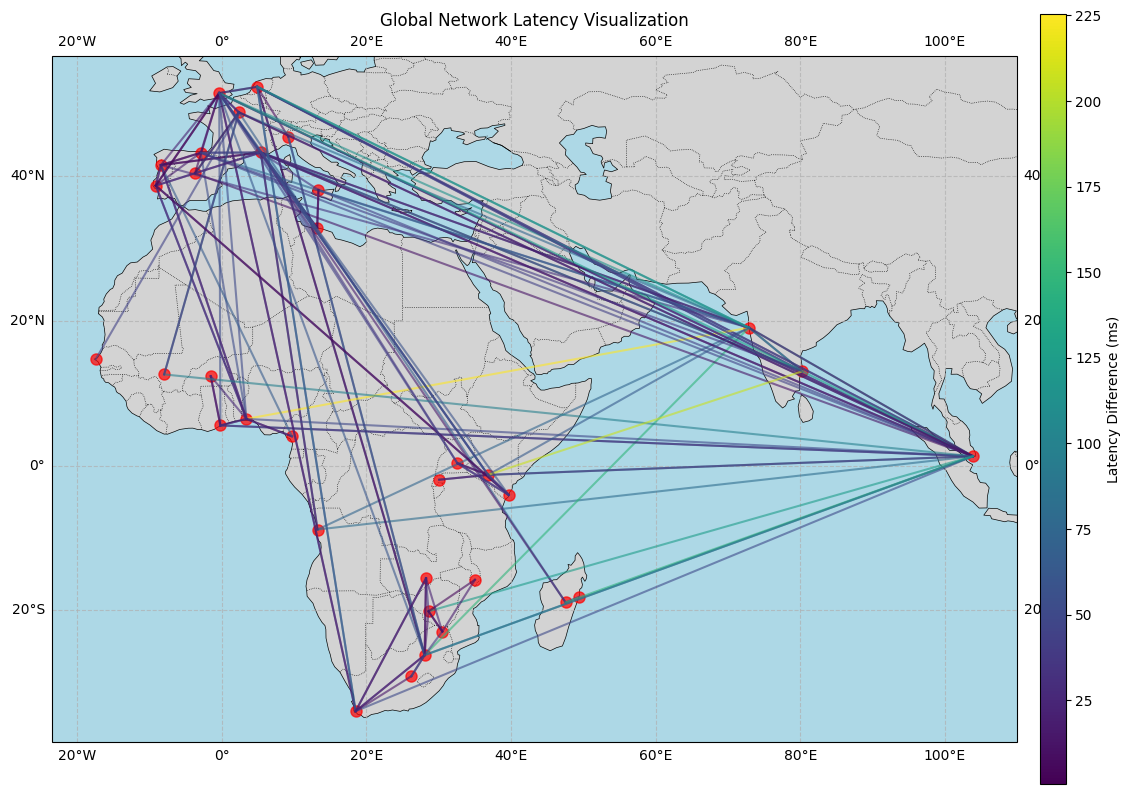

In [8]:

# Execution flow
iterations = parse_traceroute_logs('traceroute_log.txt')
merged_vertices = merge_close_locs(iterations)
edges = find_edges(iterations, merged_vertices)
plot_map(merged_vertices, edges)

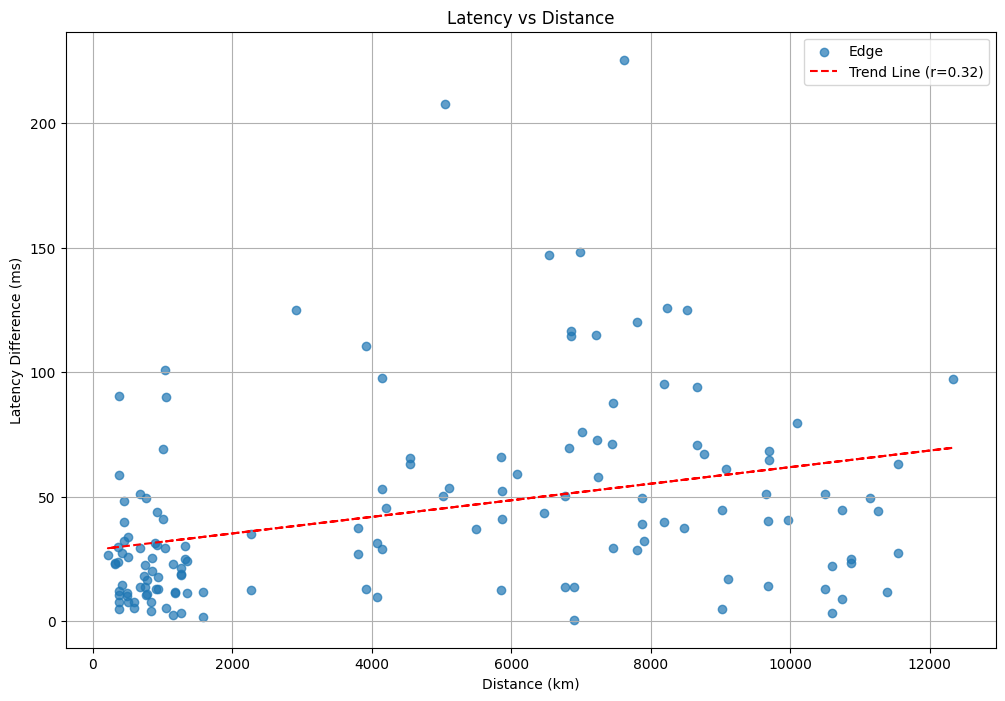

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### Scatter plot for 1(d) ###

# Calculate distances and latencies
physical_distances = []
latency_differences = []

for (src, dst), latency in edges.items():
    distance = haversine(src, dst, unit='km')
    physical_distances.append(distance)
    latency_differences.append(latency)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(physical_distances, latency_differences)

# Plot scatter with trend line
plt.figure(figsize=(12, 8))
plt.scatter(physical_distances, latency_differences, alpha=0.7, label='Edge')
plt.plot(
    physical_distances, 
    slope * np.array(physical_distances) + intercept, 
    color='red', 
    linestyle='--',
    label=f'Trend Line (r={r_value:.2f})'
)

plt.xlabel('Distance (km)')
plt.ylabel('Latency Difference (ms)')
plt.title('Latency vs Distance')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import re

def detect_load_balancing(filename):
    """Find hops with 2+ routers (per-packet load balancing), show locations and ISP."""
    total_cases = 0
    cases = []

    # Regex to extract router info
    router_re = re.compile(
        r'(\d+\.\d+\.\d+\.\d+).*?AS\d+\s+([^,]+).*?loc:\s*(-?\d+\.\d+),(-?\d+\.\d+)'
    )

    with open(filename, 'r') as f:
        for line in f:
            # Only process lines that look like hops
            if not re.match(r'^\s*\d+\s+', line):
                continue

            # Find all routers in the line
            routers = router_re.findall(line)
            unique_ips = {ip for ip, isp, lat, lon in routers} 
            # Check if there are 2 or more unique IPs in line for load balancing
            if len(unique_ips) >= 2:
                total_cases += 1
                isp = routers[0][1]
                cases.append([(ip, isp, float(lat), float(lon)) for ip, isp, lat, lon in routers])

    print(f"Total load balancing cases (2+): {total_cases}\n")
    
    for idx, routers in enumerate(cases, 1):
        print(f"Case {idx}:")
        for ip, isp, lat, lon in routers:
            print(f"  {ip:15} | {isp:30} | ({lat:.4f}, {lon:.4f})")
        print()

detect_load_balancing('traceroute_log.txt') # 1(e): analyzing per packet load balancing


Total load balancing cases (2+): 1278

Case 1:
  103.198.140.105 | Reliance Jio Infocomm Pte Ltd Singapore | (1.2897, 103.8501)
  103.198.140.54  | Reliance Jio Infocomm Pte Ltd Singapore | (19.0728, 72.8826)
  103.198.140.211 | Reliance Jio Infocomm Pte Ltd Singapore | (1.2897, 103.8501)

Case 2:
  103.198.140.215 | Reliance Jio Infocomm Pte Ltd Singapore | (1.2897, 103.8501)
  197.234.113.76  | Paratus Telecommunications Limited | (-8.8368, 13.2343)

Case 3:
  197.234.112.84  | Paratus Telecommunications Limited | (-8.8368, 13.2343)
  197.234.113.76  | Paratus Telecommunications Limited | (-8.8368, 13.2343)

Case 4:
  103.198.140.213 | Reliance Jio Infocomm Pte Ltd Singapore | (1.2897, 103.8501)
  103.198.140.54  | Reliance Jio Infocomm Pte Ltd Singapore | (19.0728, 72.8826)

Case 5:
  185.1.47.13     | Reliance Jio Infocomm Pte Ltd Singapore | (1.2897, 103.8501)
  103.198.140.176 | Reliance Jio Infocomm Pte Ltd Singapore | (19.0728, 72.8826)

Case 6:
  103.198.140.29  | Reliance Jio

In [11]:
def find_frequent_routers(filename):
    """Identify frequently occurring routers outside India with location/ISP details"""
    router_stats = defaultdict(lambda: {'count': 0, 'locations': set(), 'isps': set()})

    # Enhanced regex pattern to capture router details
    router_re = re.compile(
        r'(\d+\.\d+\.\d+\.\d+)\s+'          # IP address
        r'\(([^,]+),\s*([A-Z]{2}),\s*'      # City and country code
        r'(?:AS\d+\s+)?([^,]+),\s*'         # ISP (optional AS number)
        r'loc:\s*(-?\d+\.\d+),(-?\d+\.\d+)' # Coordinates
    )

    with open(filename, 'r') as f:
        for line in f:
            # Skip header/traceroute command lines
            if line.startswith(('traceroute', '===')) or not line.strip():
                continue
            
            # Process each router in the line
            for match in router_re.finditer(line):
                ip, city, country, isp, lat, lon = match.groups()
                
                # Skip Indian routers and local networks
                if country == 'IN' or 'local' in isp.lower():
                    continue
                
                # Record router details
                router_stats[ip]['count'] += 1
                router_stats[ip]['locations'].add(f"{city}, {country} ({lat},{lon})")
                router_stats[ip]['isps'].add(isp)

    # Filter routers appearing at least 2 times
    common_routers = {ip: data for ip, data in router_stats.items() if data['count'] >= 2}

    # Print results
    print("Frequent International Routers:")
    print("{:<15} {:<6} {:<25} {}".format("IP", "Count", "Locations", "ISPs"))
    for ip, data in sorted(common_routers.items(), key=lambda x: -x[1]['count']):
        locs = ', '.join(sorted(data['locations'])[:2])
        isps = ', '.join(sorted(data['isps']))
        print(f"{ip:<15} {data['count']:<6} {locs:<25} {isps}")

find_frequent_routers('traceroute_log.txt') # 1(f): Identifying commonly accessed routers outside India

Frequent International Routers:
IP              Count  Locations                 ISPs
154.126.20.242  105    Antananarivo, MG (-18.9137,47.5361) Telecom Malagasy
154.126.20.241  94     Antananarivo, MG (-18.9137,47.5361) Telecom Malagasy
103.198.140.45  91     Singapore, SG (1.2897,103.8501) Reliance Jio Infocomm Pte Ltd Singapore
149.14.125.1    68     Marseille, FR (43.2970,5.3811) Cogent Communications
103.198.140.43  53     Singapore, SG (1.2897,103.8501) Reliance Jio Infocomm Pte Ltd Singapore
105.16.9.13     52     Amsterdam, NL (52.3740,4.8897) SEACOM Limited
149.14.196.81   44     Slough, GB (51.5095,-0.5954) Cogent Communications
154.54.63.189   43     Lisbon, PT (38.7167,-9.1333) Cogent Communications
103.198.140.215 37     Singapore, SG (1.2897,103.8501) Reliance Jio Infocomm Pte Ltd Singapore
154.54.61.106   37     Braga, PT (41.5503,-8.4200) Cogent Communications
193.239.117.234 35     Amsterdam, NL (52.3740,4.8897)  
154.72.175.6    31     Douala, CM (4.0483,9.7043) CAMTE